# import needed modules

In [163]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tkinter as tk
from PIL import Image, ImageDraw
from scipy.ndimage import gaussian_filter

## i made the architecture of the neural network and the logistic regression with an object oriented approach to optimize readability, reusability, flexibility and scalability

## i made both logistic regression and neural network architectures so that users can compare their performance on different tasks

### for the logistic regression class nothing is complicated it just implements prediction, cost computation, gradient of the cost, gradient descent, and some  visualisation. i just focussed on the quality of the design

In [164]:
class logistic_regression_model:
    def __init__(self, X, learning_rate= 0.1, reg_param= 1):
        self.learning_rate= learning_rate
        features_number = X.shape[1]
        self.Weight = np.random.randn(features_number,1)
        self.bias = np.random.randn(1)
        self.reg_param = reg_param
    
    def sigmoid(self, z):
        return  1 / (1 + np.exp(-z))
    
    def predict(self, X):
        z = np.dot(X, self.Weight) + self.bias
        a = self.sigmoid(z)
        return a
    
    def compute_cost(self, X, y):
        epsilon = 1e-15 #small constant to prevent log of 0
        
        examples_number = X.shape[0]
        a = np.clip(self.predict(X), epsilon, 1 - epsilon)
        loss = -(y * np.log(a) + (1 - y) * np.log(1 - a))
        cost = loss.sum() / examples_number
        return cost
    
    def compute_gradient(self, X, y):
        examples_number = X.shape[0]
        a = self.predict(X)
        err = a - y
        dcost_dW = np.dot(X.T, err) / examples_number + (self.reg_param / examples_number) * self.Weight
        dcost_db = np.sum(err) / examples_number
        return (dcost_dW, dcost_db)
    
    def gradient_descent(self, X, y, num_iters= 1000, plot_train_cost= False, plot_test_cost = False, X_test = None, y_test = None):
        train_cost_hist = []
        test_cost_hist = []
        for i in range(num_iters):
            dcost_dW, dcost_db = self.compute_gradient(X, y)
            
            self.Weight -= self.learning_rate * dcost_dW
            self.bias -= self.learning_rate * dcost_db
            
            train_cost = self.compute_cost(X, y)
            train_cost_hist.append(train_cost)
            
            if plot_test_cost :
                test_cost = self.compute_cost(X_test,y_test)
                test_cost_hist.append(test_cost)
            
        if(plot_train_cost):
            plt.figure()
            plt.plot(train_cost_hist, label= 'train_cost')
            plt.title("cost history")
            plt.ylabel("cost")
            plt.xlabel("iterations")
        if(plot_test_cost):
            plt.plot(test_cost_hist, label= 'test_cost')
        if(plot_train_cost or plot_test_cost):
            plt.legend(loc= 'upper right')
            plt.show()
        return train_cost_hist,test_cost_hist
        
    def score(self, X, y):
        a = self.predict(X)
        preds = a >= 0.5
        score = (preds == y).mean()
        return score

### the neural network architecture is implemented entirely from scratch, i delved into and implemented the mathematical formulas of for prop and especially back prop calculating the partial derivatives of the cost with respect to every parameter at each iteration and implementing that efficiently using linear algebra and matrix operations

### unfortunately i can't make rigorous mathematical explanation here but i may plan to make a video or an article about it in the future and link it in the readme file, otherwise you should be able to understand the implementation if you are familiat with the mathematical formulas that are behind neural networks

### also the neural network architecture is designed for a fully connected neural network

In [165]:
class neural_network:
    def __init__(self, layers):
        self.layers_number = len(layers)
        self.layers = {f"W{i + 1}": layers[i][0] for i in range(self.layers_number)}
        self.layers.update({f"b{i + 1}": layers[i][1] for i in range(self.layers_number)})
        self.layers.update({f"activation{i + 1}": self.choose_func(layers[i][2]) for i in range(self.layers_number)})
        self.classes_count = self.layers[f"b{self.layers_number}"].shape[0]
        self.cache = dict()

    def choose_func(self, func):
        if func == "sigmoid":
            return {"function": self.sigmoid, "derivative": self.sigmoid_derivative}
        elif func == "relu":
            return {"function": self.relu, "derivative": self.relu_derivative}
        elif func == "softmax":
            return {"function": self.softmax, "derivative": self.softmax_derivative}
        else:
            raise Exception("invalid activation function!")

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def sigmoid_derivative(self, z):
        sig = self.sigmoid(z)
        return sig * (1 - sig)

    def softmax(self, z):
        z = z - np.max(z, axis=0, keepdims=True)  #avoiding large exponentials while keeping the deviation the same
        return (np.exp(z) / np.sum(np.exp(z), axis=0, keepdims=True))

    def softmax_derivative(self, z):
        gamma = self.softmax(z)
        return gamma * (1 - gamma)

    def relu(self, z):
        return np.maximum(0, z)

    def relu_derivative(self, z):
        return np.where(z > 0, 1, 0)

    def one_hot(self, y):
        y = y.astype(int)
        m = y.shape[1]
        one_hotted = np.zeros((self.classes_count, m))
        one_hotted[y[0,:], np.arange(m)] = 1
        return one_hotted

    def forword_propagation(self, X):
        A = X  #dim : (n(features),m)
        self.cache["A0"] = A
        for i in range(self.layers_number):
            W = self.layers[f"W{i + 1}"]  #dim : (n(curr layer), n(prev layer))
            b = self.layers[f"b{i + 1}"]  #dim : (n(curr layer), 1)
            Z = np.dot(W, A) + b  #dim : (n(curr layer), m)
            act_func = self.layers[f"activation{i + 1}"]["function"]
            A = act_func(Z)  #dim : (n(curr layer), m)

            self.cache[f"A{i + 1}"] = A
            self.cache[f"Z{i + 1}"] = Z

        return self.cache[f"A{self.layers_number}"]

    def back_propagation(self, X, y, reg_param, learning_rate):
        samples_number = X.shape[1]
        one_hotted_y = self.one_hot(y)
        dz = self.cache[f"A{self.layers_number}"] - one_hotted_y  #(n(last layer), m)
        for i in range(self.layers_number, 0, -1):
            A = self.cache[f"A{i - 1}"]  #dims : (n(prev layer),m)

            #calculating the derivatives
            dcost_dW = (np.dot(dz,
                               A.T) / samples_number)  #+ (reg_param / samples_number) * self.layers[f"W{i}"] #dims : (n(curr layer), n(prev layer))
            dcost_db = np.sum(dz, axis=1, keepdims=True) / samples_number  #dims : (n(curr layer), 1)

            #updating dz for the next iteration:
            if i > 1:
                Z = self.cache[f"Z{i - 1}"]
                W = self.layers[f"W{i}"]
                act_deriv = self.layers[f"activation{i - 1}"]["derivative"]
                dz = np.dot(W.T, dz) * act_deriv(Z)

            #updating the weights and biases
            self.layers[f"W{i}"] -= learning_rate * dcost_dW  #updating the weights
            self.layers[f"b{i}"] -= learning_rate * dcost_db  #updating the biases

    def compute_cost(self, X, y, reg_param):
        epsilon = 1e-15  #small constant to prevent log of 0
        one_hotted_y = self.one_hot(y)
        examples_number = X.shape[1]
        self.forword_propagation(X)
        a = np.clip(self.cache[f"A{self.layers_number}"], epsilon, 1 - epsilon)
        loss = -np.log(a) * one_hotted_y
        cost = loss.sum() / examples_number
        # l2_reg_term = (reg_param / (2 * examples_number)) * sum([np.sum(np.square(self.layers[f"W{i+1}"])) for i in range(self.layers_number)])
        # reg_cost = cost + l2_reg_term

        return cost

    def fit(self, X, y, reg_param=1, batch_size=32, epochs=1000, learning_rate=0.01):
        m = X.shape[1]
        cost_his = []
        iterations = []
        for epoch in range(epochs):
            for batch in range((m) // batch_size):
                start = batch * batch_size
                end = start + batch_size

                X_batch = X[:, start: end]
                y_batch = y[:, start: end]

                self.forword_propagation(X_batch)
                self.back_propagation(X_batch, y_batch, reg_param, learning_rate)

            if (m % batch_size) != 0:
                start = m - (m % batch_size)
                end = m

                X_batch = X[:, start: end]
                y_batch = y[:, start: end]

                self.forword_propagation(X_batch)
                self.back_propagation(X_batch, y_batch, reg_param, learning_rate)
            if (epoch + 1) % (epochs // 10) == 0:
                cost = self.compute_cost(X, y, reg_param)
                cost_his.append(cost)
                iterations.append(epoch + 1)
                print(f"epoch {epoch + 1}, cost: {cost:.4f}")
        plt.figure()
        plt.plot(iterations, cost_his, label='train_cost')
        plt.title("cost history")
        plt.ylabel("cost")
        plt.xlabel("iterations")
        plt.show()

    def score(self, X, y):
        self.forword_propagation(X)
        a = self.cache[f"A{self.layers_number}"]
        preds = (a >= 0.5).astype(int)
        one_hotted_y = self.one_hot(y)
        error = np.any(preds != one_hotted_y, axis=0).mean()
        return 1 - error
    def get_params_to_save(self):
        params = []
        for i in range(self.layers_number):
            params.append([self.layers[f"W{i+1}"], self.layers[f"b{i+1}"], self.layers[f"activation{i+1}"]["function"].__name__])
        return params


In [166]:
def Dense(units, activation):
    return [units, activation]

In [167]:
def make_layers(X,dense_layers):
    np.random.seed(1)
    n1 = X.shape[0]
    
    layers = []
    for i in range(len(dense_layers)):
        n2 = dense_layers[i][0]
        W = np.random.randn(n2,n1)
        b = np.random.randn(n2,1)
        activation = dense_layers[i][1]
        layers.append([W, b, activation])
        
        n1 = n2
    return layers

## after implementing the neural network. it is time to read and prepare the data  for the model, nothing is complicated here, the format of the data is also very easy to deal with as pandas has a built in function for reading from csv files

In [168]:
train_set = pd.read_csv("datasets/mnist_train.csv")
train_set.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [169]:
train_set.describe()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
count,60000.000000,60000.0,60000.0,60000.0,60000.0,60000.0,60000.0,60000.0,60000.0,60000.0,...,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.0000,60000.0,60000.0,60000.0,60000.0
mean,4.453933,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.200433,0.088867,0.045633,0.019283,0.015117,0.0020,0.0,0.0,0.0,0.0
std,2.889270,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.042472,3.956189,2.839845,1.686770,1.678283,0.3466,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.000000,254.000000,62.0000,0.0,0.0,0.0,0.0


# just extracting the training dataset and and the test dataset and separating the features and the labels

In [170]:
X_train = train_set.drop("label", axis= "columns").to_numpy().astype(float)
X_train.shape

(60000, 784)

In [171]:
X_train.dtype

dtype('float64')

In [172]:
y_train = train_set.loc[:,"label"].to_numpy()
y_train.shape

(60000,)

In [173]:
y_train.dtype

dtype('int64')

## just adjusting the format and the shape of the data to be suitable for training the model

In [174]:
X_train = X_train.T
y_train = y_train.reshape((-1, 1)).T
print(y_train)
y_train.shape

[[5 0 4 ... 5 6 8]]


(1, 60000)

In [175]:
print("X_train.shape: ", X_train.shape)
print("y_train.shape:", y_train.shape)

X_train.shape:  (784, 60000)
y_train.shape: (1, 60000)


In [176]:
test_data = pd.read_csv("datasets/mnist_test.csv")
X_test = test_data.drop("label", axis= "columns").to_numpy().astype(float).T
y_test = test_data.loc[:,"label"].to_numpy().reshape(-1, 1).T

print("X_test.shape: ", X_test.shape)
print("y_test.shape:", y_test.shape)

X_test.shape:  (784, 10000)
y_test.shape: (1, 10000)


## normalizing the data is too important to avoid very large values as the training and the cost computation includes exponentials which can lead overflow or other problems (note that exp(200) is a number that is larger than the number of atoms in the universe!)

In [177]:
X_train = X_train / 255
X_test = X_test / 255

In [178]:
print("max of X_train:", np.max(X_train))
print("minimum of X_train", np.min(X_train))

max of X_train: 1.0
minimum of X_train 0.0


# initialize parameters

In [179]:
layers = make_layers(X_train, [Dense(16, "relu"),
                               Dense(16, "relu"),
                               Dense(10, "softmax")])

# create a neural network and initialize it with parameters

In [180]:
model = neural_network(layers)

# train the neural network

epoch 100, cost: 0.3653
epoch 200, cost: 0.2729
epoch 300, cost: 0.2281
epoch 400, cost: 0.2033
epoch 500, cost: 0.1861
epoch 600, cost: 0.1739
epoch 700, cost: 0.1644
epoch 800, cost: 0.1557
epoch 900, cost: 0.1486
epoch 1000, cost: 0.1427


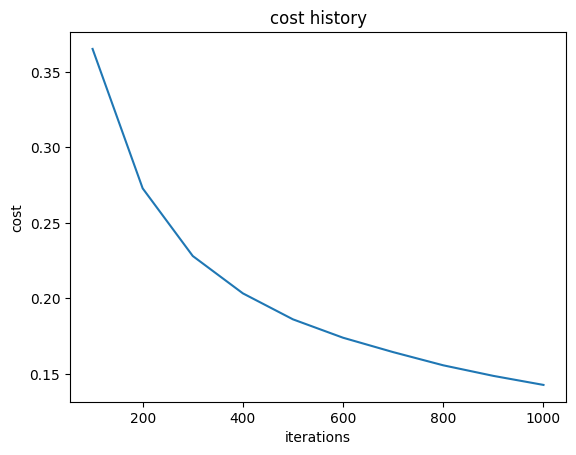

In [181]:
model.fit(X_train, y_train, learning_rate= 0.01, epochs= 1000)

# evaluating the precistion of the model on the train and test set

In [182]:
model.score(X_train, y_train)

np.float64(0.95235)

In [183]:
model.score(X_test, y_test)

np.float64(0.9398)

# making an interactive feature to take input from the user and output the prediction of the model on it

In [191]:
class HandwrittenDigitApp:
    def __init__(self):
        self.window = tk.Tk()
        self.window.title("Handwritten Digit Input")

        self.drawing_area = tk.Canvas(self.window, width=280, height=280, bg="white")
        self.drawing_area.pack()

        self.drawing_area.bind('<B1-Motion>', self.draw_stroke)
        self.drawing_area.bind('<ButtonRelease-1>', self.on_release)

        self.sketch = Image.new("L", (28, 28), "white")
        self.sketch_drawer = ImageDraw.Draw(self.sketch)

        self.done_button = tk.Button(self.window, text="Submit", command=self.submit_sketch)
        self.done_button.pack()

        self.processed_digit = None

    def draw_stroke(self, event):
        x_start, y_start = event.x - 1, event.y - 1
        x_end, y_end = event.x + 1, event.y + 1
        self.drawing_area.create_oval(x_start, y_start, x_end, y_end, fill="black", width=20)
        self.sketch_drawer.line([x_start / 10, y_start / 10, x_end / 10, y_end / 10], fill="black", width=2)

    def submit_sketch(self):
        img_array = np.array(self.sketch)
        self.processed_digit = 1 - img_array.reshape(28, 28, 1) / 255.0 
        np.save('digit_image.npy', img_array)
        self.window.quit()

def collect_digit():
    app = HandwrittenDigitApp()
    app.window.mainloop()
    app.window.destroy()
    return app.processed_digit

def apply_gaussian_blur(img):
    # Apply Gaussian blur with a sigma value for removing unnecessary data
    return gaussian_filter(img, sigma=0.5)

def collect_and_predict(model):
    digit_image = collect_digit()
    blurred_image = apply_gaussian_blur(digit_image)

    reshaped_image = blurred_image.reshape(1, 784).T
    print("Model Prediction:", np.argmax(model.forword_propagation(reshaped_image)))

    # Display the processed image
    plt.imshow(reshaped_image.reshape((28, 28)), cmap='gray')
    plt.show()


Model Prediction: 2


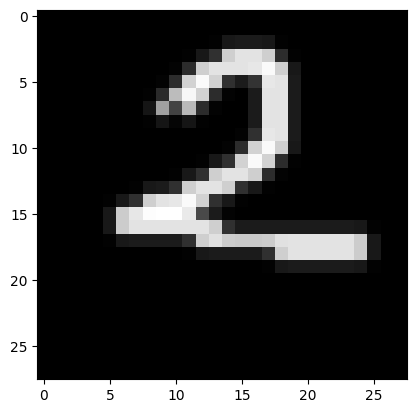

In [193]:
collect_and_predict(model)

# evaluating the model on the test set

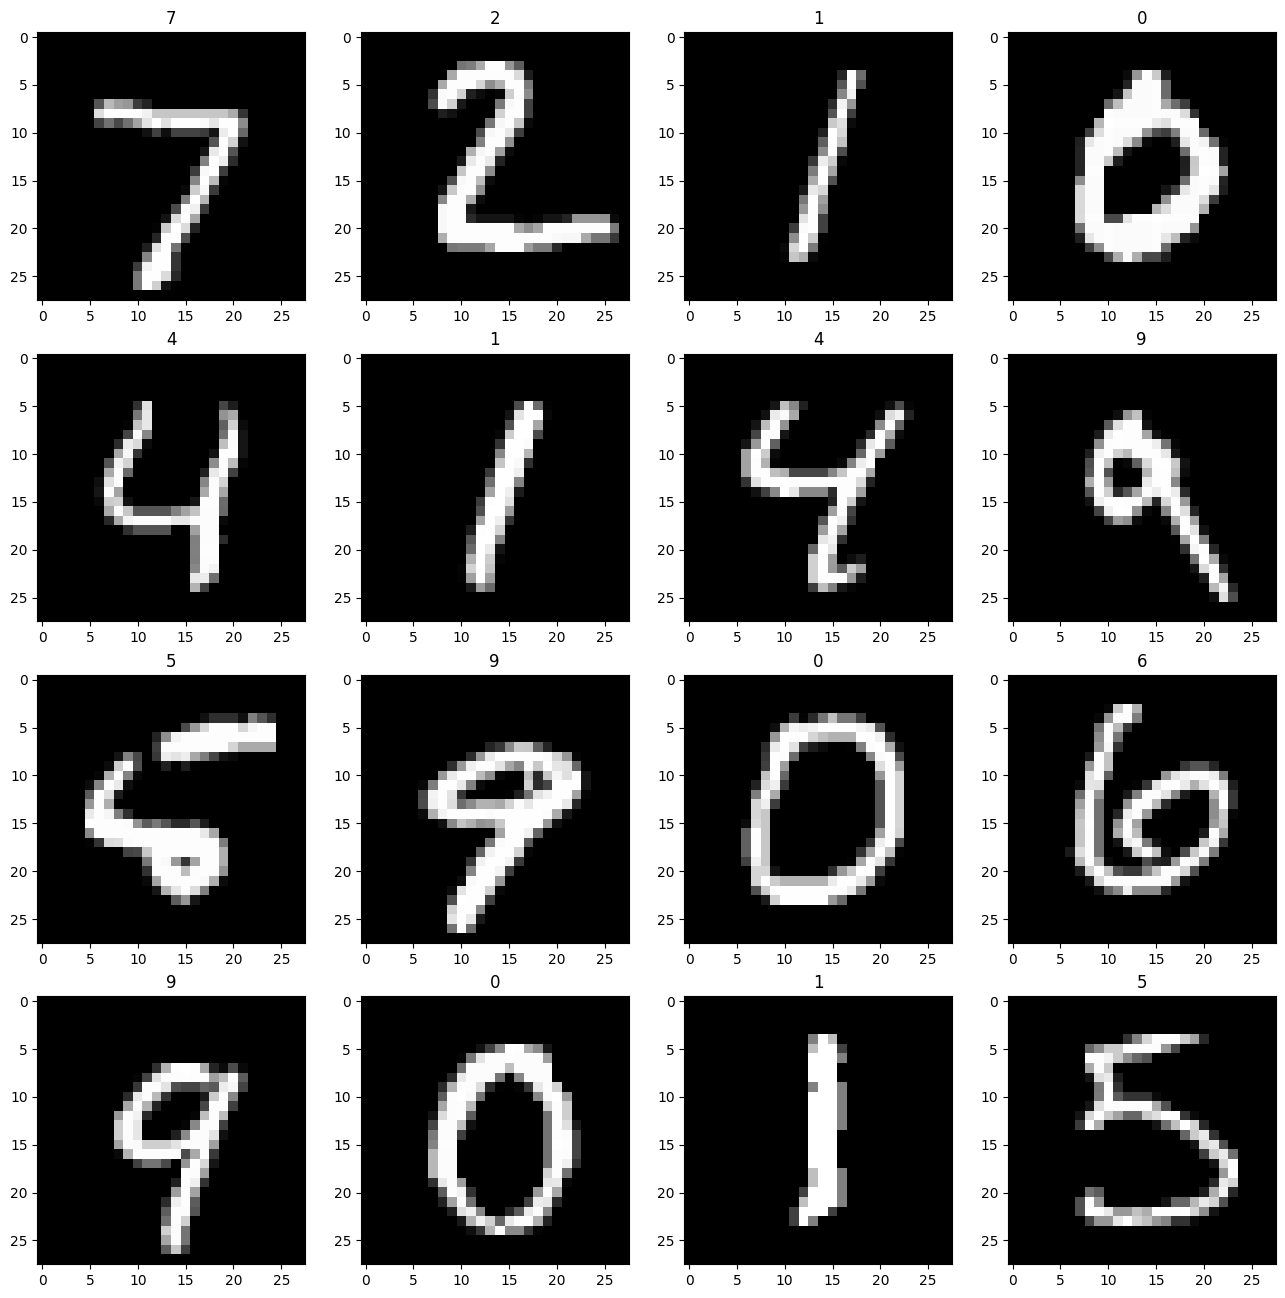

In [186]:
fig, ax = plt.subplots(4,4,figsize= (16,16))
for i in range(4):
    for j in range(4):
        ax[i][j].imshow(X_test[:,4*i+j].reshape((28,28)), cmap= 'gray')
        ax[i][j].set_title(np.argmax(model.forword_propagation(X_test[:,4*i+j].reshape((-1, 1)))))
plt.show()

# saving the parameters into a text file

In [187]:
import json
params_to_save = [[param.tolist() if isinstance(param, np.ndarray) else param for param in model.get_params_to_save()[i]] for i in range(model.layers_number)]
with open("params.txt", "w") as file:
    json.dump(params_to_save, file)

# reading the saved parameters from the text file

In [188]:
with open('params.txt', 'r') as file:
    loaded_params = json.load(file)
    new_params = [[np.array(param) if isinstance(param, list) else param for param in loaded_params[i]] for i in range(model.layers_number)]